# AI in Finance: Seminar IV.

## Initialization

In [126]:
# imports:

## basic libraries:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import math
import matplotlib
## modelling:
import statsmodels.formula.api as smf

In [128]:
# data
ocr = pd.read_csv("../data/ocr.csv").drop("Unnamed: 0", axis=1)  # the ocr is our train set
oct = pd.read_csv("../data/oct.csv").drop("Unnamed: 0", axis=1)  # the oct is the test set

In [129]:
# settings
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [5]:
ocr.describe()

,price,km,age,km10,power_lowest,power_low,power_mid,power_high,power_highest,ba,...,za,diesel,petrol,petgas,man,eng1,eng2,eng3,eng4,eng6
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,...,720.000000,720.000000,720.0000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,13696.583333,172.708687,6.605556,0.011111,0.029167,0.204167,0.230556,0.368056,0.159722,0.233333,...,0.120833,0.880556,0.1125,0.006944,0.500000,0.126389,0.069444,0.212500,0.063889,0.263889
std,5786.612018,70.462335,3.675650,0.104895,0.168390,0.403372,0.421481,0.482612,0.366603,0.423247,...,0.326160,0.324536,0.3162,0.083101,0.500348,0.332518,0.254385,0.409361,0.244725,0.441046
min,1400.000000,0.006000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9490.000000,132.953250,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13990.000000,171.677500,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.0000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16900.000000,210.001750,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.0000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,34900.000000,500.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1 OLS Models

At this point, we write down formulas that specify all of our models. These are nested in a dictionary for easier manipulation
I use the formula-based Statsmodels API syntax

### 1.1 Models Fitting

In [19]:
model_formulas = {
    "m1": "price ~ km",
    "m2": "price ~ age",
    "m3": "price ~ km + age",
    "m4": "price ~ km + age + km10 + power_lowest + power_low + power_mid + power_high + "
          "power_highest + ba + bb + ke + nr + po + tn + tt + petrol + petgas + man + eng1 + "
          "eng2 + eng3 + eng4 + eng6",
    "m5": "price ~ km + I(km**2) + age + I(age**2) + diesel + man + eng1 + eng2 + eng3 + eng4 + eng6"
}

The following function iterates over all models and returns the fitted objects

In [20]:
def fit_ols_models(models_specs: dict, data: pd.DataFrame) -> dict:
    """
    Purpose: For the specified formulas, fit the OLS model and return all its attributes
    """

    models_fitted = {}
    for model, formula in models_specs.items():
        models_fitted[model] = smf.ols(formula=formula, data=data).fit()

    return models_fitted

In [24]:
models_res = fit_ols_models(model_formulas, ocr)  # object containing all fitted models

The following function iterates over all of our fitted models and prints summary tables with all respective summary tables

In [121]:
def print_models_summary(models_res_list: dict) -> None:
    """
    Purpose: Print summary tables for each model from the dictionary of fitted models
    """

    for mod, res in models_res_list.items():
        print(f"{mod}:\n\n "
              f"Coefficients: \n"
              f"{res.summary()} \n\n")

In [122]:
print_models_summary(models_res)

m1:

 Coefficients: 
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     877.3
Date:                Sun, 16 Oct 2022   Prob (F-statistic):          1.34e-126
Time:                        10:54:02   Log-Likelihood:                -6971.3
No. Observations:                 720   AIC:                         1.395e+04
Df Residuals:                     718   BIC:                         1.396e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.421e+04    383.48

### 1.2 Models Evaluation

Now that we've fitted the model, it's time to evaluate our results. First we generate predicitons based on our models.

In [130]:
def generate_predictions(models_fitted: dict, data_test: pd.DataFrame) -> dict:
    """
    Purpose: For all fitted models, generate predictions for the test set and store them in a dictionary
    """
    pred_vals = {}
    for model, specs in models_fitted.items():
        pred_vals[model] = specs.predict(data_test)

    return pred_vals

In [131]:
oct_pred = generate_predictions(models_res, oct)

We can plot the actual values in our test set against the predictions. This has the same effect as the residual analysis.
We can therefore check if the predicitons substantially differ for different values of our target variable

In [151]:
from sklearn.metrics import mean_squared_error as mse
def compare_models_metrics(preds_dict, data_observed, metric, print_res=False):

    metric_dict = {}

    for mod, fit in preds_dict.items():
        metric_dict[mod] = metric(preds_dict[mod], data_observed)
        # metric_dict[mod] = mse(data_observed, preds_dict[mod])

    if print_res:
        for key, val in sorted(metric_dict.items(), key = lambda x: x[1], reverse=False) :
            print(f"Model {key} had the metric score of of: {val}\n")

    return metric_dict

In [160]:
mse_dta = compare_models_metrics(oct_pred, oct[['price']], mse, True)

Model m5 had the metric score of of: 3376994.6205662224

Model m4 had the metric score of of: 4643638.6376971

Model m3 had the metric score of of: 7082020.1644274555

Model m2 had the metric score of of: 11002840.766313981

Model m1 had the metric score of of: 13486177.111468973



In [132]:
def get_grid_shape(data):
    """
    Purpose: Helper function to create a tupe which would determine the subplots shape
    """
    grid_size = (math.ceil(np.sqrt(len(data))), math.floor(np.sqrt(len(data))))

    return grid_size

In [156]:
def actual_vs_fit_plot(fitted, actuals, mse):
    """
    Purpose: Generate scatter plots to plot the actual values against the fitted ones
    """
    shape = get_grid_shape(fitted)

    fig, axs = plt.subplots(shape[0], shape[1], figsize=tuple([5*x for x in shape]))
    fig.suptitle("Actual vs. Fitted values Regression Plot")
    i = 0
    j = 0
    for model, vals in fitted.items():
        sns.regplot(ax=axs[i, j % 2], x=vals, y=actuals, line_kws={'color': 'red'})
        axs[i, j % 2].set_title(f"{model}: MSE of {round(mse[model])}")
        i = i + j
        j = (j + 1) % 2

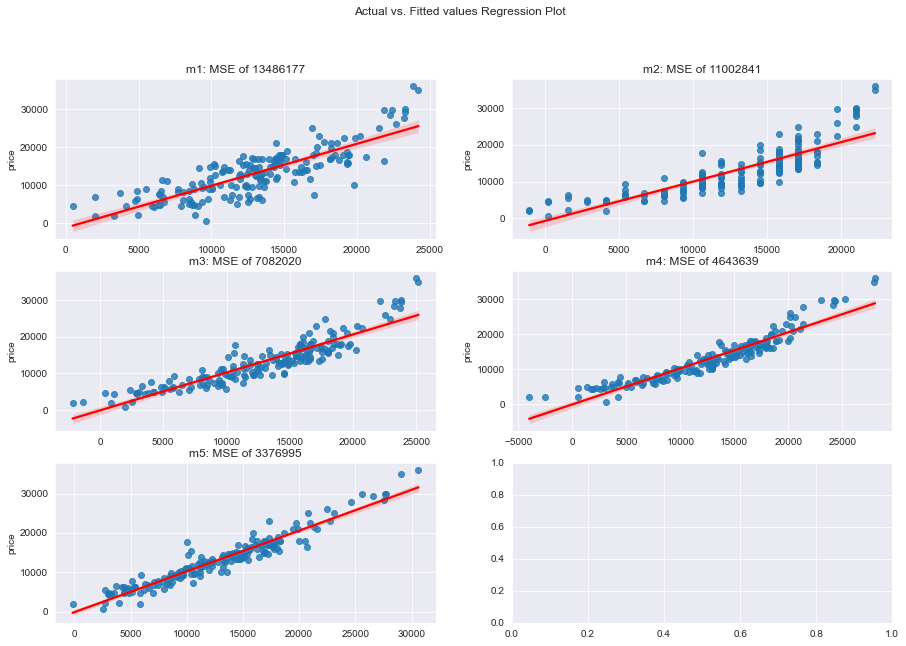

In [157]:
actual_vs_fit_plot(oct_pred, oct[['price']], mse_dta)

## 2 Bootstraping

At first, I initialize the functionction which is meant to extract the coefficients of our regression

In [ ]:
def est_model(data, formula):
    # bootstrap() makes an array, not a DataFrame
    estimate = smf.ols(formula, data).fit()
    coefs = estimate.params

    return coefs

In [ ]:
def get_bootstrap_coefs(data, n_rep, formula):
    res = []

    for i in range(n_rep):
        smpl = data.sample(frac=1, replace=True)
        model = smf.ols(formula, smpl).fit()
        coefs = model.params

        res.append(coefs)

    return pd.DataFrame(res, columns=coefs.index)


In [ ]:
bs_c = get_bootstrap_coefs(ocr, 1000, model_formulas['m4'])


In [ ]:
def get_quantiles(data, q_list = [0.01, 0.5, 0.99]):

    df_q = data.quantile(q_list).set_index(pd.Index([q for q in q_list])).transpose()

    return df_q

In [ ]:
def get_stats(data, alpha, q_list):

    stats_dict = {
        'mean': data.mean(),
        'std': data.std(),
        'se': data.std()/np.sqrt(data.shape[0]),
        't_stat': stats.t.ppf(q=1 - alpha/2, df=data.shape[0] - 1),
        'quantiles': data.quantile(q_list).set_index(pd.Index([q for q in q_list])).transpose()
    }

    return stats_dict




In [ ]:
x = get_stats(bs_c, 0.01, [0.01, 0.5, 0.99])

In [ ]:
x['t_stat']

### 2.2 MCS

In this part, I examine our models using the Model Confidence Set. The class I use is taken from the [M. Gong's implementation](https://michael-gong.com/blogs/model-confidence-set/) of the algorithm.

In [189]:
from AI.util.MCS import ModelConfidenceSet as MCS

In [207]:
mcs_oct = MCS((pd.DataFrame(oct_pred)
              .apply(lambda x: np.abs(x - oct['price'])))
              , 0.01, 3, 1000).run()

In [208]:
mcs_oct.pvalues

m1    0.0
m2    0.0
m3    0.0
m4    0.0
m5    1.0
dtype: float64

### 2.3 Regularized Regression